In [22]:
import os
import gym
import gym_maze
import numpy as np
import random
import time
import tqdm

import json

In [23]:
for i in tqdm.tqdm_notebook(range(1)):
    pass
for i in tqdm.notebook.tqdm(range(1)):
    pass

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [24]:
actions = {0: 'move south',
1: 'move north',
2: 'move east',
3: 'move west',
4: 'pickup passenger',
5: 'drop off passenger'}
    
action_n = 6
state_n = 500


actions = {0: 'move south',
1: 'move north',
2: 'move east',
3: 'move west',
4: 'pickup passenger',
5: 'drop off passenger'}
    

positions = {0: 'Red',
1: 'Green',
2: 'Yellow',
3: 'Blue',
4: 'in taxi'}

In [25]:
def delivered(state):
    taxi_row, taxi_col, passenger_location, destination = env.decode(state)
    return passenger_location == destination

In [41]:
class CrossEntropyMethod():
    def __init__(self, name, state_n, action_n, lambd):
        self.name = name
        self.lambd = lambd
        self.state_n = state_n
        self.action_n = action_n
        self.policy = np.ones((self.state_n, self.action_n)) / self.action_n
    
    def get_action(self, state):
        return int(np.random.choice(np.arange(self.action_n), p=self.policy[state]))
    
    def update_policy(self, elite_trajectories):
        pre_policy = np.zeros((self.state_n, self.action_n))
        
        # counter
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                pre_policy[state][action] += 1
        
        # 
        for state in range(self.state_n):
            if sum(pre_policy[state]) == 0:
                self.policy[state] = np.ones(self.action_n) / self.action_n
            else:
                self.policy[state] = pre_policy[state] / sum(pre_policy[state])
        self.save_policy()
        return None
    def laplace_update_policy(self, elite_trajectories, lambd):
        pre_policy = np.zeros((self.state_n, self.action_n))
        
        # counter
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                pre_policy[state][action] += 1
        
        # 
        for state in range(self.state_n):
            if sum(pre_policy[state]) == 0:
                self.policy[state] = np.ones(self.action_n) / self.action_n
            else:
                self.policy[state] = (pre_policy[state]+lambd) / (sum(pre_policy[state])+lambd*self.action_n)
        self.save_policy()
        return None
    def policy_smoothing_update(self, elite_trajectories, lambd):
        pre_policy = np.zeros((self.state_n, self.action_n))
        
        # counter
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                pre_policy[state][action] += 1
        
        # 
        for state in range(self.state_n):
            if sum(pre_policy[state]) == 0:
                new_policy = np.ones(self.action_n) / self.action_n
            else:
                new_policy = pre_policy[state] / sum(pre_policy[state])
            self.policy[state] = lambd*new_policy+ (1-lambd)*self.policy[state]
        self.save_policy()
        return None
    def save_policy(self):
        np.save(f'{env.spec.id}-{self.name}', self.policy)
    def load_policy(self):
        fname = f'{env.spec.id}-{self.name}.npy'
        if os.path.exists(fname):
            self.policy = np.load(fname)

In [42]:
def get_trajectory(env, agent, trajectory_len):
    trajectory = {
        'states':[], 
        'actions':[],
        'total_reward': 0}

    state = env.reset()
    trajectory['states'].append(state)
    
    for _ in range(trajectory_len):
        action = agent.get_action(state)
        trajectory['actions'].append(action)
        state, reward, done, _ = env.step(action)
        trajectory['states'].append(state)
        trajectory['total_reward'] += reward
        if done:
            break
    return trajectory

In [59]:
a = np.arange(-100, -1)
q =     np.quantile(a, q=0.9) 
[ai for ai in a if ai> q]

[-11, -10, -9, -8, -7, -6, -5, -4, -3, -2]

In [43]:
def get_elite_trajectories(trajectories, q_param):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param) 
    return [trajectory for trajectory in trajectories if trajectory['total_reward'] > quantile]


In [35]:
env = gym.make("Taxi-v3")


In [375]:
#Taxi
action_n = 6
state_n = 500
episode_n = 50
trajectory_len = 200
trajectory_n =  100
q_param = 0.8
lambd = 0.6
env = gym.make("Taxi-v3")
name = f'{episode_n}_{trajectory_len}_{trajectory_n}_{lambd}'
print(name)
agent = CrossEntropyMethod(name, state_n, action_n)

50_200_100_0.6


Laplass experiment

E\[G\] dependency of trajectory_n vs lambda

In [44]:
def experiment(episode_n, trajectory_len, trajectory_n, q_param, lambd, position):
    exp = {
        'episode_n':episode_n,
        'trajectory_len':trajectory_len,
        'trajectory_n':trajectory_n,
        'q_param':q_param,
        'lamd':lambd,
        'episode_data':[]
    }
    name = f'cem_{episode_n}_{trajectory_len}_{trajectory_n}_{q_param}_{lambd}'
    agent = CrossEntropyMethod(name, state_n, action_n, lambd)

    env = gym.make("Taxi-v3")
    episode_data = []
    for _ in tqdm.notebook.tqdm(range(episode_n), desc='Episodes '+str(episode_n)+' '+str(trajectory_n), position=position):
        trajectories = [get_trajectory(env, agent, trajectory_len) for _ in range(trajectory_n)]

        mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])

        elite_trajectories = get_elite_trajectories(trajectories, q_param)
        episode_data.append((mean_total_reward, len(elite_trajectories)))
        if len(elite_trajectories) > 0:
            agent.update_policy(elite_trajectories)
    exp['episode_data'] = episode_data
    json.dump(exp, open(f'./experiments/{name}.json','w'))


In [45]:
def policy_smoothing_experiment(episode_n, trajectory_len, trajectory_n, q_param, lambd, position):
    exp = {
        'episode_n':episode_n,
        'trajectory_len':trajectory_len,
        'trajectory_n':trajectory_n,
        'q_param':q_param,
        'lamd':lambd,
        'episode_data':[]
    }
    name = f'policy_{episode_n}_{trajectory_len}_{trajectory_n}_{q_param}_{lambd}'
#     print('................')
#     print('episode_n', episode_n)
#     print('trajectory_len', trajectory_len)
#     print('trajectory_n', trajectory_n)
#     print('q_param', q_param)
#     print('lamdb', lamdb)
    agent = CrossEntropyMethod(name, state_n, action_n, lambd)
    env = gym.make("Taxi-v3")
    episode_data = []
    for _ in tqdm.notebook.tqdm(range(episode_n), desc='Episodes '+str(episode_n)+' '+str(trajectory_n), position=position):
        trajectories = [get_trajectory(env, agent, trajectory_len) for _ in range(trajectory_n)]

        mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])

        elite_trajectories = get_elite_trajectories(trajectories, q_param)
        episode_data.append((mean_total_reward, len(elite_trajectories)))
        if len(elite_trajectories) > 0:
            agent.policy_smoothing_update(elite_trajectories, lambd)
#         print(mean_total_reward, len(elite_trajectories))
    exp['episode_data'] = episode_data
    json.dump(exp, open(f'./experiments/{name}.json','w'))
    # ani = animation.FuncAnimation(fig, animate, interval=1000)


In [46]:
def laplase_experiment(episode_n, trajectory_len, trajectory_n, q_param, lambd, position):
    exp = {
        'episode_n':episode_n,
        'trajectory_len':trajectory_len,
        'trajectory_n':trajectory_n,
        'q_param':q_param,
        'lamd':lambd,
        'episode_data':[]
    }
    name = f'laplase_{episode_n}_{trajectory_len}_{trajectory_n}_{q_param}_{lambd}'
#     print('................')
#     print('episode_n', episode_n)
#     print('trajectory_len', trajectory_len)
#     print('trajectory_n', trajectory_n)
#     print('q_param', q_param)
#     print('lamdb', lamdb)
    agent = CrossEntropyMethod(name, state_n, action_n, lambd)
    env = gym.make("Taxi-v3")
    episode_data = []
    for _ in tqdm.notebook.tqdm(range(episode_n), desc='Episodes', position=position):
        trajectories = [get_trajectory(env, agent, trajectory_len) for _ in range(trajectory_n)]

        mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])

        elite_trajectories = get_elite_trajectories(trajectories, q_param)
        episode_data.append((mean_total_reward, len(elite_trajectories)))
        if len(elite_trajectories) > 0:
            agent.laplace_update_policy(elite_trajectories, lambd)
#         print(mean_total_reward, len(elite_trajectories))
    exp['episode_data'] = episode_data
    json.dump(exp, open(f'./experiments/{name}.json','w'))
    # ani = animation.FuncAnimation(fig, animate, interval=1000)


In [47]:
def get_tasks(episodes_n, trajectories_len, trajectories_n, q_params, lambdas):
    tasks = []
    for episode_n in episodes_n:
        for trajectory_len in trajectories_len:
            for trajectory_n in trajectories_n:
                for q_param in q_params:
                    for lambd in lambdas:
                        tasks.append((episode_n, trajectory_len, trajectory_n, q_param, lambd))
    return tasks

In [74]:
episodes_n = [20]#, 100]
trajectories_len = [200]
# trajectories_n =  [20, 40, 80, 160, 320, 640, 1280, 2560, 2560*2, 2560*4]
trajectories_n =  [1280]
q_params = [0.9]
trajectories_n =  [20, 40, 80, 160, 320, 640, 1280, 2560, 2560*2, 2560*4]
lambdas = [ 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]
# env = gym.make("Taxi-v3")
# name = f'{episode_n}_{trajectory_len}_{trajectory_n}_{lambd}'
# print(name)
# agent = CrossEntropyMethod(name, state_n, action_n)

In [144]:
episodes_n = [100]
trajectories_len = [200]
trajectories_n =  [640]
q_params = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
lambdas = [0.1]#, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
# env = gym.make("Taxi-v3")
# name = f'{episode_n}_{trajectory_len}_{trajectory_n}_{lambd}'
# print(name)
# agent = CrossEntropyMethod(name, state_n, action_n)

In [49]:
episodes_n = [100]
trajectories_len = [200]
trajectories_n =  [640]
q_params = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
lambdas = [0.1]

tasks = get_tasks(episodes_n, trajectories_len, trajectories_n, q_params, lambdas)

episodes_n = [100]
trajectories_len = [200]
trajectories_n =  [20, 40, 80, 160, 320, 640, 1280]
q_params = [0.2]
lambdas = [0.1]

tasks += get_tasks(episodes_n, trajectories_len, trajectories_n, q_params, lambdas)

for task in tqdm.notebook.tqdm(tasks, desc='Tasks'):
    print(task)
    experiment(*task, position=3)
#     laplase_experiment(*task, position=3)
#     policy_smoothing_experiment(*task, position=3)

(100, 200, 640, 0.1, 0.1)
(100, 200, 640, 0.2, 0.1)
(100, 200, 640, 0.3, 0.1)
(100, 200, 640, 0.4, 0.1)
(100, 200, 640, 0.5, 0.1)
(100, 200, 640, 0.6, 0.1)
(100, 200, 640, 0.7, 0.1)
(100, 200, 640, 0.8, 0.1)
(100, 200, 640, 0.9, 0.1)
(100, 200, 640, 0.95, 0.1)
(100, 200, 640, 0.99, 0.1)
(100, 200, 20, 0.2, 0.1)
(100, 200, 40, 0.2, 0.1)
(100, 200, 80, 0.2, 0.1)
(100, 200, 160, 0.2, 0.1)
(100, 200, 320, 0.2, 0.1)
(100, 200, 640, 0.2, 0.1)
(100, 200, 1280, 0.2, 0.1)



In [ ]:
episodes_n = [100]
trajectories_len = [200]
trajectories_n =  [20, 40, 80, 160, 320, 640, 1280]
q_params = [0.2]
lambdas = [0.1]

tasks = get_tasks(episodes_n, trajectories_len, trajectories_n, q_params, lambdas)
for task in tqdm.notebook.tqdm(tasks, desc='Tasks'):
    print(task)
#     experiment(*task, position=3)
    laplase_experiment(*task, position=3)
#     policy_smoothing_experiment(*task, position=3)

In [61]:
episodes_n = [100]
trajectories_len = [200]
trajectories_n =  [640]
q_params = [0.5]
lambdas = [0.1, 0.2, 0.3 , 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

tasks = get_tasks(episodes_n, trajectories_len, trajectories_n, q_params, lambdas)
for task in tqdm.notebook.tqdm(tasks, desc='Tasks'):
    print(task)
#     experiment(*task, position=3)
#     laplase_experiment(*task, position=3)
    policy_smoothing_experiment(*task, position=3)

(100, 200, 640, 0.5, 0.1)



(100, 200, 640, 0.5, 0.2)



(100, 200, 640, 0.5, 0.3)



(100, 200, 640, 0.5, 0.4)



(100, 200, 640, 0.5, 0.5)



(100, 200, 640, 0.5, 0.6)



(100, 200, 640, 0.5, 0.7)



(100, 200, 640, 0.5, 0.8)



(100, 200, 640, 0.5, 0.9)


In [62]:
experiment(100, 200, 40, 0.5, 0.1, position=3)


In [64]:
experiment(100, 200, 2560, 0.5, 0.1, position=3)


In [65]:
policy_smoothing_experiment(100, 200, 40, 0.5, 0.5, position=3)
policy_smoothing_experiment(100, 200, 160, 0.5, 0.5, position=3)
policy_smoothing_experiment(100, 200, 2560, 0.5, 0.5, position=3)



In [66]:
laplase_experiment(100, 200, 40, 0.5, 0.5, position=3)
laplase_experiment(100, 200, 160, 0.5, 0.5, position=3)
laplase_experiment(100, 200, 2560, 0.5, 0.5, position=3)



In [ ]:
# comparing PS LS CEM
episodes_n = [100]
trajectories_len = [200]
trajectories_n =  [40,  160, 640, 2560]
q_params = [0.5]
lambdas = [0.5]

tasks = get_tasks(episodes_n, trajectories_len, trajectories_n, q_params, lambdas)
for task in tqdm.notebook.tqdm(tasks, desc='Tasks'):
    print(task)
    experiment(*task, position=3)
    laplase_experiment(*task, position=3)
    policy_smoothing_experiment(*task, position=3)

In [40]:
laplase_experiment(11, 200, 10, 0.9, 0.9, 55)

Episodes: 100%|██████████| 11/11 [00:02<00:00,  5.16it/s]


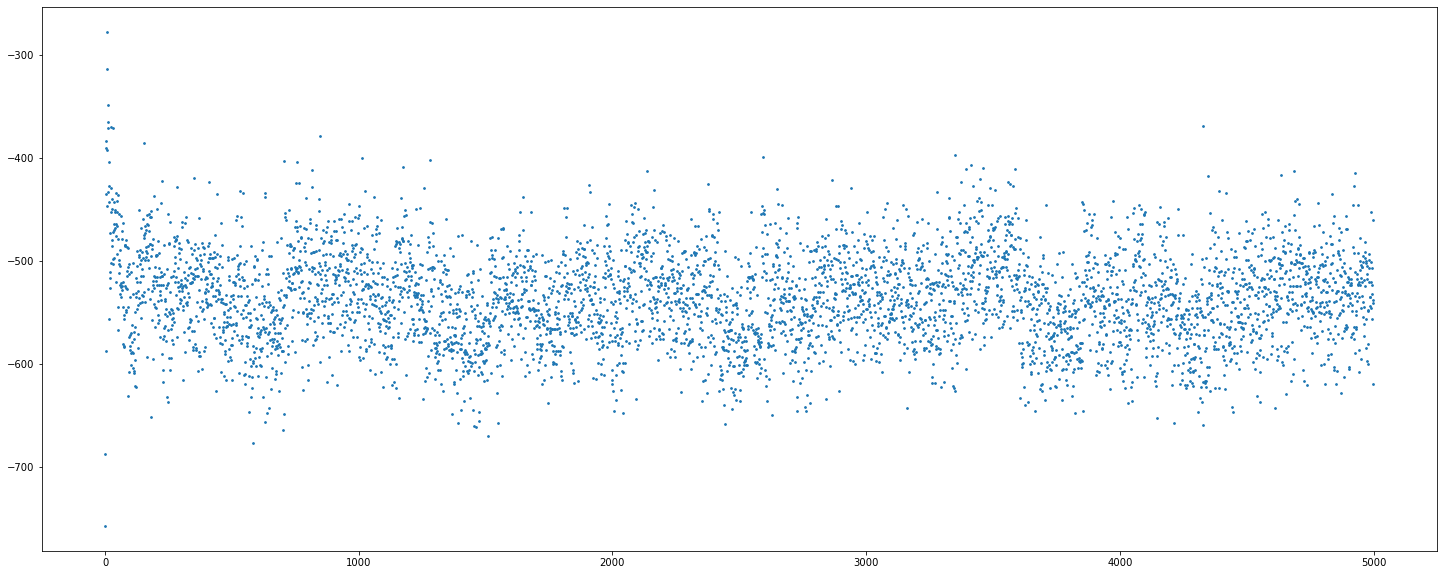

In [374]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(1,1,1)
ax1.scatter(range(len(episode_data)), np.array(episode_data)[::,0], s=3)
plt.show()


In [37]:
env = gym.make("Taxi-v3")
episode_data = []
for _ in tqdm.tqdm(range(episode_n)):
    trajectories = [get_trajectory(agent, trajectory_len) for _ in range(trajectory_n)]
    
    mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
    
    elite_trajectories = get_elite_trajectories(trajectories, q_param)

    episode_data.append((mean_total_reward, len(elite_trajectories)))
#     print(mean_total_reward, len(elite_trajectories))
    
    if len(elite_trajectories) > 0:
        agent.laplace_update_policy(elite_trajectories)

  0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'agent' is not defined

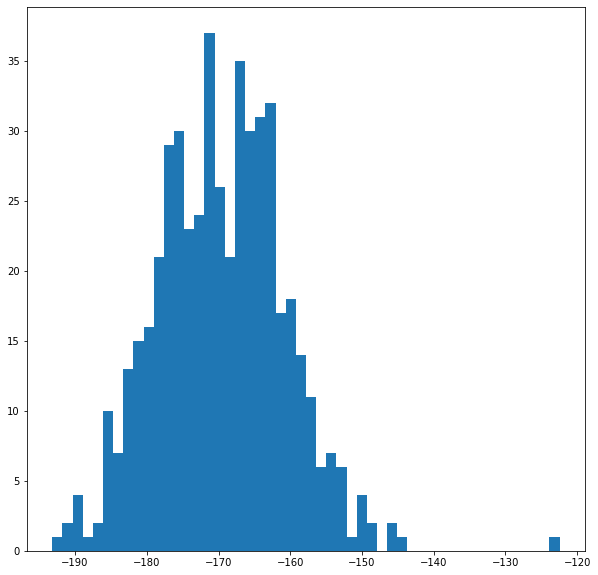

In [67]:
plt.figure(figsize=(10,10))
plt.hist(np.array(episode_data)[::,0], bins=50)
plt.show()

In [165]:
trajectory_len

20

In [489]:
agent2 = CrossEntropyMethod('agent2', state_n, action_n)

In [490]:
agent2.policy = np.load('Taxi-v3-500x500.npy')

In [491]:
agent2.policy

array([[0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        ],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       ...,
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667]])

In [ ]:
episodes_n = [100]
trajectories_len = [10]
trajectories_n =  [20]
det_policies_n = [100]
q_params = [0.1, 0.5, 0.9]

In [70]:
#Taxi
action_n = 6
state_n = 500
episode_n = 60
trajectory_len = 20
trajectory_n =  20
q_param = 0.5
# lambd = 0.6
env = gym.make("Taxi-v3")
name = f'{episode_n}_{trajectory_len}_{trajectory_n}'
print(name)
agent = CrossEntropyMethod(name, state_n, action_n, 0)

60_20_20


In [ ]:
agent.polic = np.load(open(./Taxi-v3-det_CEM_100_30_10_0.5_0.1.npy))

In [333]:
#test

trajectory_len = 20
trajectory_len = 20

env = gym.make("Taxi-v3")

final_rewards = []
state = env.reset()
env.render()
time.sleep(1)
taxi_row, taxi_col, passenger_location, destination = env.decode(state)
print(taxi_row, taxi_col, passenger_location, destination)
test_reward = 0
for step in range(trajectory_len):
    action = agent.get_action(state)
    state, reward, done, _ = env.step(action)
    test_reward += reward
    env.render()
    if done:
#             print(state,f'{test_reward:04}', actions[action])
#         зкште
        break
    time.sleep(0.5)
taxi_row, taxi_col, passenger_location, f_destination = (env.decode(state))
print(taxi_row, taxi_col, passenger_location, destination, action)
final_rewards.append([test_reward, action, step])
#     print('Test Reward', test_reward)

4 0 1 2
0 3 4 2 3


In [502]:
#test
env = gym.make("Taxi-v3")

final_rewards = []
for _ in tqdm.notebook.tqdm(range(1001)):
    state = env.reset()
    taxi_row, taxi_col, passenger_location, destination = env.decode(state)
#     print(taxi_row, taxi_col, passenger_location, destination)
    test_reward = 0
    for step in range(trajectory_len):
        action = agent2.get_action(state)
        state, reward, done, _ = env.step(action)
        test_reward += reward
    #     env.render()
        if done:
#             print(state,f'{test_reward:04}', actions[action])
            break
    #     time.sleep(0.5)
    taxi_row, taxi_col, passenger_location, f_destination = (env.decode(state))
#     print(taxi_row, taxi_col, passenger_location, destination, action)
    final_rewards.append([test_reward, step, delivered(state)])
#     print('Test Reward', test_reward)

final_rewards = np.array(final_rewards)

In [503]:
sum(final_rewards[::,2])

298

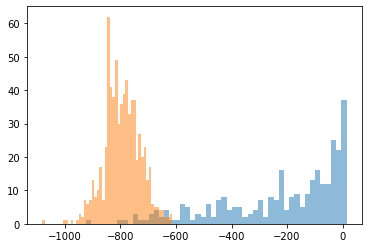

In [504]:
plt.hist(final_rewards[final_rewards[::,2]==1][::,0], bins=50, alpha=0.5)
plt.hist(final_rewards[final_rewards[::,2]==0][::,0], bins=50, alpha=0.5)
plt.show()

In [485]:
final_rewards

array([[-776,  199,    0],
       [-767,  199,    0],
       [-731,  199,    0],
       ...,
       [-641,  199,    0],
       [-839,  199,    0],
       [-857,  199,    0]])

(array([  4.,   8.,   4.,   3.,   9., 972.]),
 array([ 20.        ,  49.83333333,  79.66666667, 109.5       ,
        139.33333333, 169.16666667, 199.        ]),
 <a list of 6 Patch objects>)

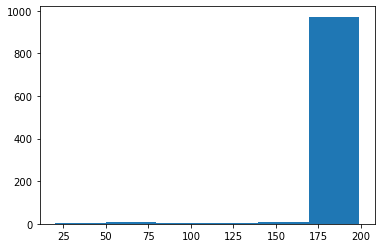

In [484]:
plt.hist(final_rewards[::,1], bins=6)

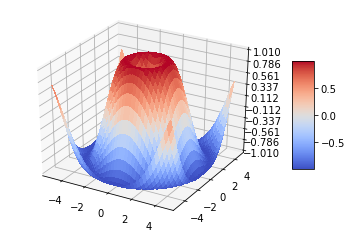

In [116]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


In [121]:
Y.shape

(40, 40)

In [120]:
Z.shape

(40, 40)

In [117]:
X

array([[-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       ...,
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
       [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75]])

In [23]:
from matplotlib import pyplot as plt

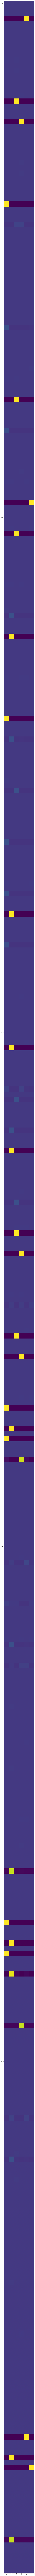

In [227]:
fig, ax = plt.subplots(figsize=(5,500))
# plt.figure(figsize=(1,1))
im = ax.imshow(agent.policy)